In [ ]:
#Importing all the required libraries for running this project

import glob
import os
import librosa as lib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import librosa.display
import numpy as np
import IPython.display as ipd
import shutil
import soundfile
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import shutil
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


In [ ]:
#Extract the file names from the audio files
def get_files(path):
    files = [file for file in glob.glob(path)]
    return files

In [ ]:
#Creating dataframe from the labelled audio files having duration equal to and more than 3 seconds
def create_dataframe(dataframe_name):
    audio = {"file_path":[],"label":[]}
    unlabelled_files = ["Aunlabelledtest", "Bunlabelledtest"]
    for folder in [INPUT_DIR+"set_a/",INPUT_DIR+"set_b/"]:
      files = get_files(folder + "//**")
      for file in files:
          label = os.path.basename(file).split("_")[0]
          if ((lib.get_duration(filename=file)>=3) and (label not in unlabelled_files)):
              audio["file_path"].append(file)
              audio["label"].append(label)

    dataframe_name = pd.DataFrame(audio)
    return dataframe_name

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
INPUT_DIR="/content/drive/MyDrive/kaggleAPI/Input/"

In [ ]:
#Creating a dataframe for the input audio data
raw_data = create_dataframe("raw_data")
raw_data

<ipython-input-3-805602ee1cf5>:9: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  if ((lib.get_duration(filename=file)>=3) and (label not in unlabelled_files)):


file_path     label
0    /content/drive/MyDrive/kaggleAPI/Input/set_a/a...  artifact
1    /content/drive/MyDrive/kaggleAPI/Input/set_a/a...  artifact
2    /content/drive/MyDrive/kaggleAPI/Input/set_a/a...  artifact
3    /content/drive/MyDrive/kaggleAPI/Input/set_a/a...  artifact
4    /content/drive/MyDrive/kaggleAPI/Input/set_a/a...  artifact
..                                                 ...       ...
457  /content/drive/MyDrive/kaggleAPI/Input/set_b/n...    normal
458  /content/drive/MyDrive/kaggleAPI/Input/set_b/n...    normal
459  /content/drive/MyDrive/kaggleAPI/Input/set_b/n...    normal
460  /content/drive/MyDrive/kaggleAPI/Input/set_b/n...    normal
461  /content/drive/MyDrive/kaggleAPI/Input/set_b/n...    normal

[462 rows x 2 columns]

In [ ]:
#Plotting Data Category Distribution
def data_distribution(data):
    plt.figure(figsize=(8,5))
    value_counts = data.label.value_counts()
    ax = value_counts.plot(kind='bar', title="Data Category distribution", xlabel="Labels", width=0.6,color='midnightblue')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

    # Add data points on top of the bars
    for i, v in enumerate(value_counts):
        ax.text(i, v, str(v), ha='center', va='bottom')

    plt.show()

In [ ]:
#Plotting spectogram of an audio signal having
def spectrogram(file_path,label):
    y, sr = lib.load(file_path)
    plt.figure(figsize=(16,3))
    plt.title(label + " Log-Frequency Power Spectrogram")
    data = lib.amplitude_to_db(np.abs(lib.stft(y)), ref=np.max)
    lib.display.specshow(data, y_axis='log',x_axis='time')
    plt.colorbar();

In [ ]:
import librosa.display

In [ ]:
#finding the unique lables in the raw dataset
unique_labels = raw_data.label.unique()
unique_labels

array(['artifact', 'extrahls', 'murmur', 'normal', 'extrastole'],
      dtype=object)

In [ ]:
#Plotting Waveform of an audio signal having
def waveform(file_path,label):
    y, sr = lib.load(file_path)
    plt.figure(figsize=(16,3))
    plt.title(label + " Sound Wave")
    librosa.display.waveshow(y)
    #lib.display.waveshow(y,sr)

/content/drive/MyDrive/kaggleAPI/Input/set_a/artifact__201106010602.wav


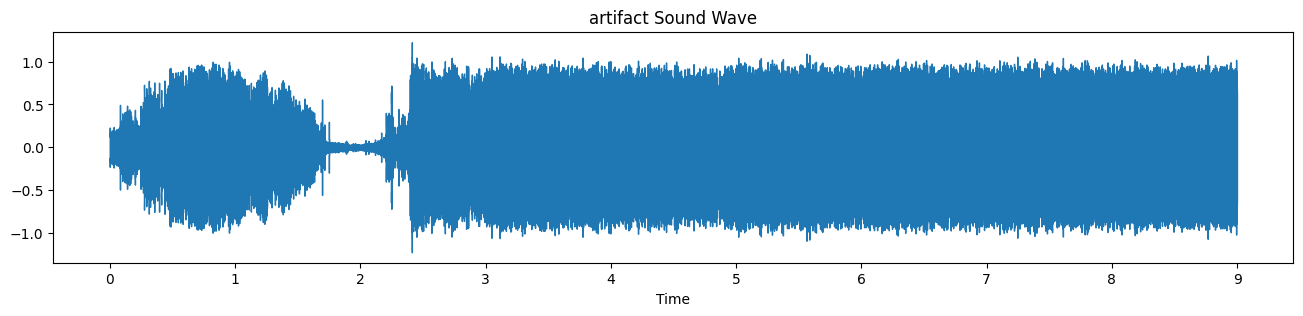

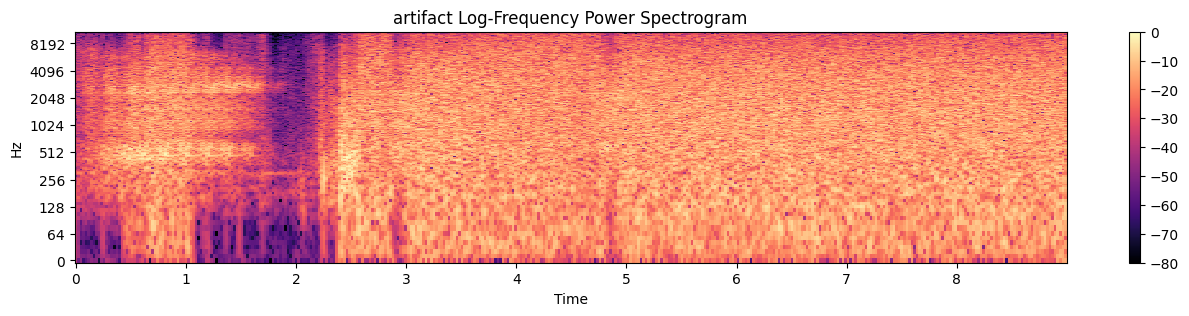

In [ ]:
#Plotting graphs for Artifact Heartbeat Sound
path = raw_data[raw_data.label==unique_labels[0]].file_path.iloc[3]
print(path)
waveform(path,unique_labels[0])
spectrogram(path,unique_labels[0])
ipd.Audio(path)

/content/drive/MyDrive/kaggleAPI/Input/set_a/extrahls__201101070953.wav


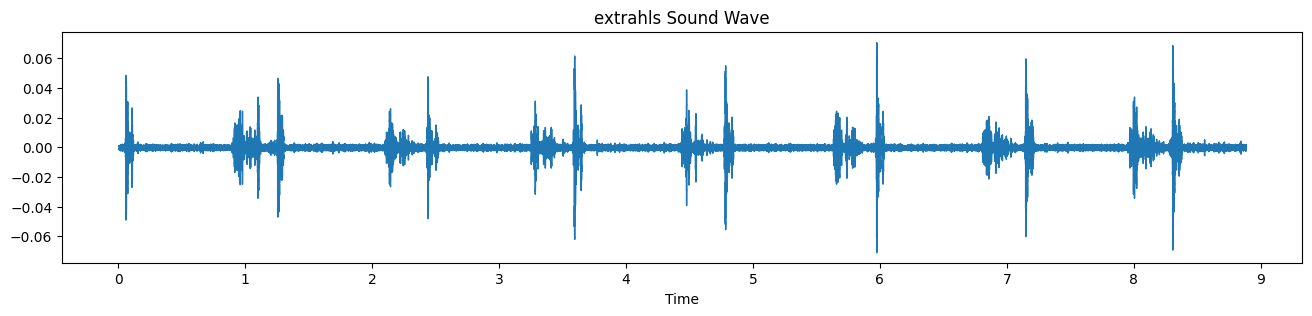

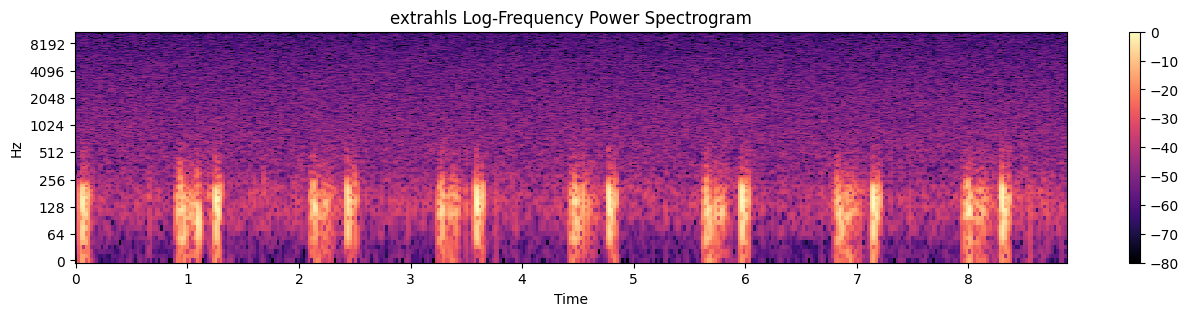

In [ ]:
#Plotting graphs for Normal Heartbeat Sound
path = raw_data[raw_data.label==unique_labels[1]].file_path.iloc[0]
print(path)
waveform(path,unique_labels[1])
spectrogram(path,unique_labels[1])
ipd.Audio(path)

/content/drive/MyDrive/kaggleAPI/Input/set_a/murmur__201101180902.wav


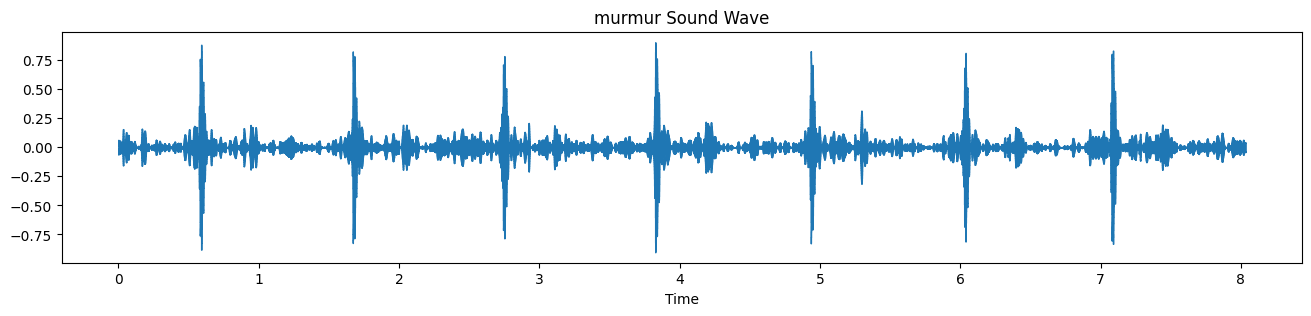

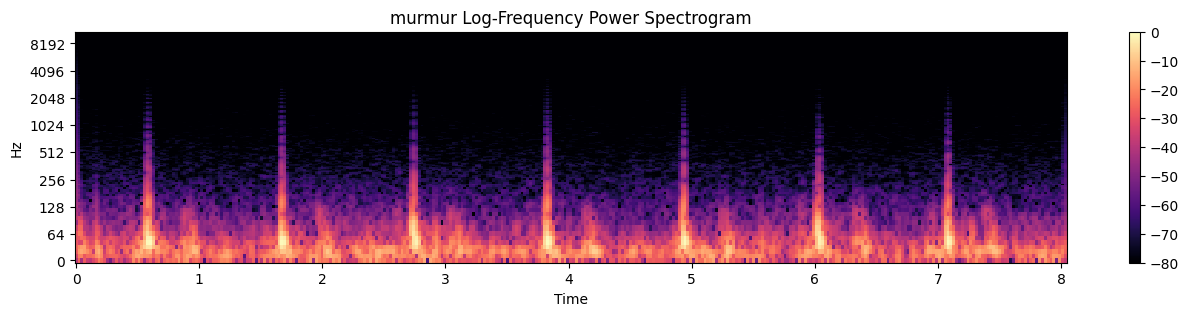

In [ ]:
#Plotting graphs for Murmur Heartbeat Sound
path = raw_data[raw_data.label==unique_labels[2]].file_path.iloc[0]
print(path)
waveform(path,unique_labels[2])
spectrogram(path,unique_labels[2])
ipd.Audio(path)

/content/drive/MyDrive/kaggleAPI/Input/set_a/normal__201102201230.wav


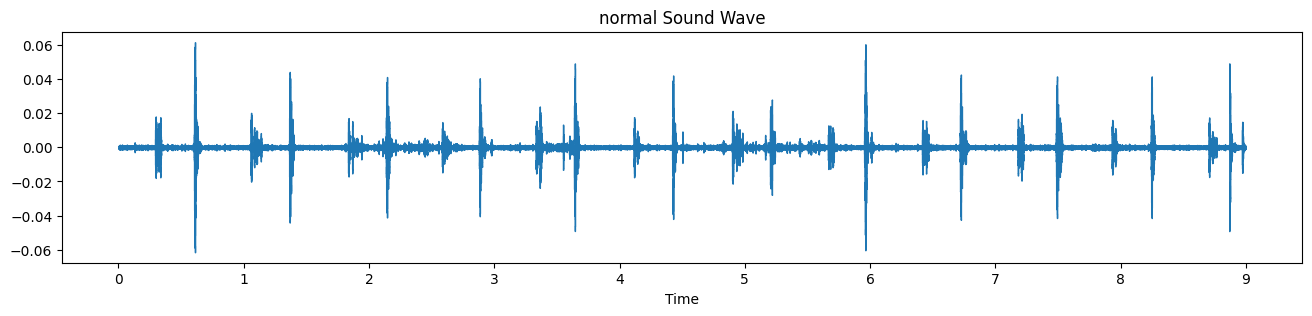

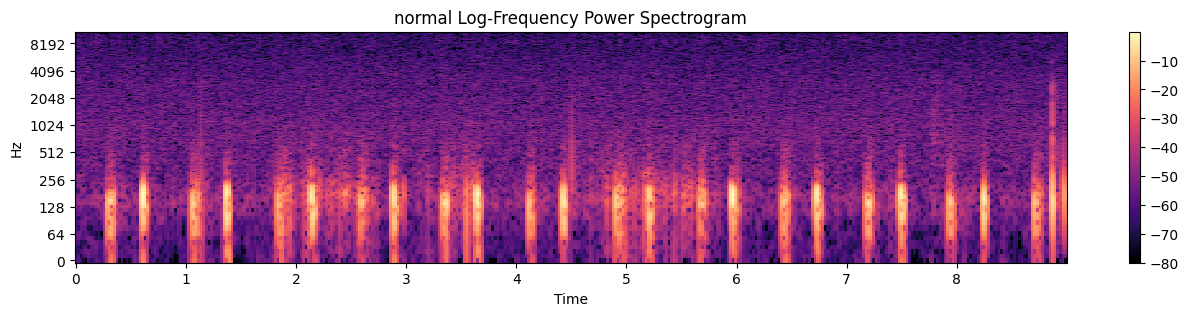

In [ ]:
#Plotting graphs for artifact Heartbeat Sound
path = raw_data[raw_data.label==unique_labels[3]].file_path.iloc[0]
print(path)
waveform(path,unique_labels[3])
spectrogram(path,unique_labels[3])
ipd.Audio(path)

/content/drive/MyDrive/kaggleAPI/Input/set_b/extrastole__151_1306779785624_B.wav


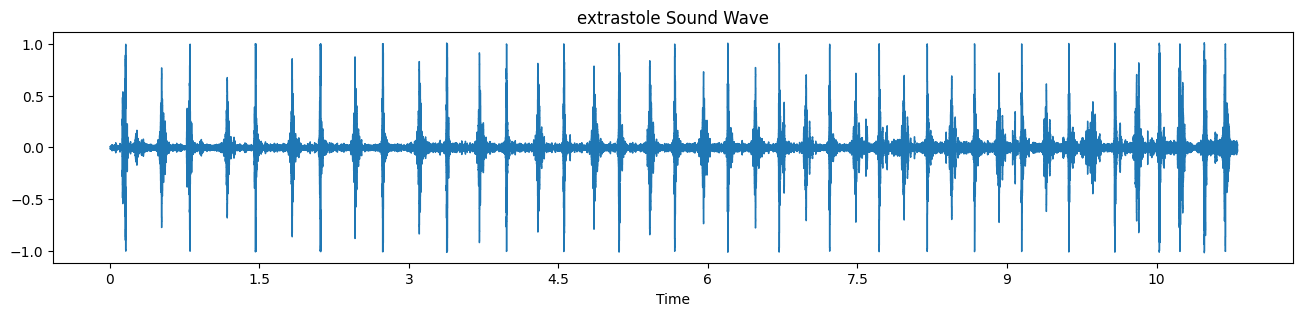

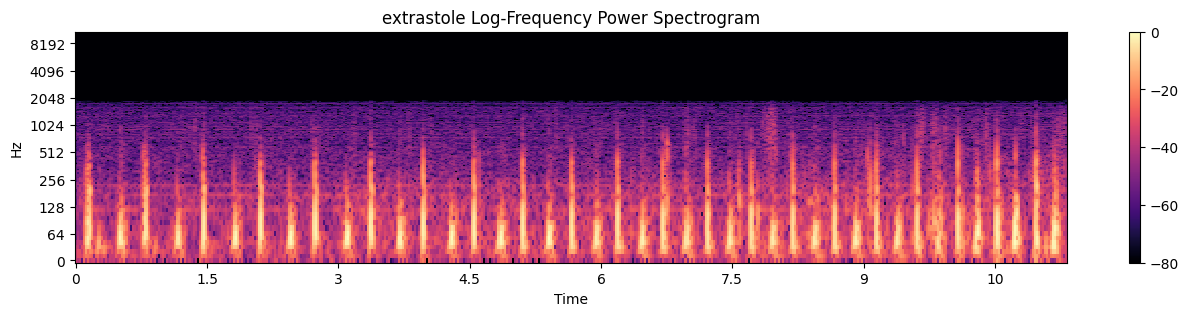

In [ ]:
#Plotting graphs for Extrahls Heatbeat Sound
path = raw_data[raw_data.label==unique_labels[4]].file_path.iloc[4]
print(path)
waveform(path,unique_labels[4])
spectrogram(path,unique_labels[4])
ipd.Audio(path)

In [ ]:

#Creating new audio files by using Data Augmentation Technique¶


In [ ]:
#Changing only the speed of an audio signal with different rates and saving it
def changing_speed(speed_rate,src_path,dst_path):
    files = get_files(src_path + "//**")
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    for file in tqdm(files):
        label = os.path.basename(file).split(".")[0]
        y, sr = lib.load(file)
        updated_y = lib.effects.time_stretch(y, rate=speed_rate)
        soundfile.write(dst_path +"//" + label + "_" + str(speed_rate) + ".wav",updated_y, sr)

In [ ]:
#Changing only the pitch of an audio signal with different steps and saving it
def changing_pitch(step,src_path,dst_path):
    files = get_files(src_path + "//**")
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    for file in tqdm(files):
        label = os.path.basename(file).split(".")[0]
        y, sr = lib.load(file)
        updated_y = lib.effects.pitch_shift(y, sr, n_steps=step)
        soundfile.write(dst_path +"//" + label + "_" + str(step) + ".wav",updated_y, sr)

In [ ]:
#Creating new files from changing pitch and speed of the input audio files
def sound_augmentation(src_path,dst_path):
    speed_rates = [1.08,0.8,1.10,0.9]
    for speed_rate in speed_rates:
        changing_speed(speed_rate,src_path,dst_path)

    steps = [2,-2,2.5,-2.5]
    for step in steps:
        changing_pitch(step,src_path,dst_path)

    files = get_files(src_path + "//**")
    for f in files:
        shutil.copy(f,dst_path)

In [ ]:
%cd /content/drive/MyDrive/kaggleAPI/Input/
!mkdir Data2


/content/drive/MyDrive/kaggleAPI/Input
mkdir: cannot create directory ‘Data2’: File exists


In [ ]:
import os
import shutil

source = "/content/drive/MyDrive/kaggleAPI/Input/set_a/"
destination = "/content/drive/MyDrive/kaggleAPI/Input/Data2/"
# Get a list of files in the source directory
file_list = os.listdir(source)

# Iterate over the files and copy them to the destination directory
for file_name in file_list:
    source_file = os.path.join(source, file_name)
    destination_file = os.path.join(destination, file_name)
    shutil.copy2(source_file, destination_file)

In [ ]:
source = "/content/drive/MyDrive/kaggleAPI/Input/set_b"
destination = "/content/drive/MyDrive/kaggleAPI/Input/Data2/"
# Get a list of files in the source directory
file_list = os.listdir(source)

# Iterate over the files and copy them to the destination directory
for file_name in file_list:
    source_file = os.path.join(source, file_name)
    destination_file = os.path.join(destination, file_name)
    shutil.copy2(source_file, destination_file)

In [ ]:
#Creating new files from changing pitch and speed of the input audio files
def sound_augmentation(src_path,dst_path):
    speed_rates = [1.08,0.8,1.10,0.9]
    for speed_rate in speed_rates:
        changing_speed(speed_rate,src_path,dst_path)

    steps = [2,-2,2.5,-2.5]
    for step in steps:
        changing_pitch(step,src_path,dst_path)

    files = get_files(src_path + "//**")
    for f in files:
        shutil.copy(f,dst_path)

In [ ]:
#Changing only the pitch of an audio signal with different steps and saving it
def changing_pitch(step,src_path,dst_path):
    files = get_files(src_path + "//**")
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    for file in tqdm(files):
        label = os.path.basename(file).split(".")[0]
        y, sr = lib.load(file)
        updated_y = lib.effects.pitch_shift(y, sr=sr, n_steps=step)
        soundfile.write(dst_path +"//" + label + "_" + str(step) + ".wav",updated_y, sr)

In [ ]:
%cd /content/drive/MyDrive/kaggleAPI/Input/
!mkdir OUT


/content/drive/MyDrive/kaggleAPI/Input
mkdir: cannot create directory ‘OUT’: File exists


In [ ]:
#Checking and creating new directory for saving newly generated audio files using data augmentation
if os.path.exists("/content/drive/MyDrive/kaggleAPI/Input/OUT"):
    if len(get_files("/content/drive/MyDrive/kaggleAPI/Input/OUT//**")) == 4175:
        print("Sound Augumentation Already Done and Saved")
    else:
        shutil.rmtree('/content/drive/MyDrive/kaggleAPI/Input/OUT')
        sound_augmentation("/content/drive/MyDrive/kaggleAPI/Input/Data2","/content/drive/MyDrive/kaggleAPI/Input/OUT")
else:
    sound_augmentation("/content/drive/MyDrive/kaggleAPI/Input/Data2","/content/drive/MyDrive/kaggleAPI/Input/OUT")

100%|██████████| 832/832 [01:31<00:00,  9.07it/s]


In [ ]:
#Creating dataframe from the labelled audio files having duration equal to and more than 3 seconds

def create_dataframe(dataframe_name):
    audio = {"file_path":[],"label":[]}
    unlabelled_files = ["Aunlabelledtest", "Bunlabelledtest"]
    for folder in ["/content/drive/MyDrive/kaggleAPI/Input/OUT/"]:
      files = get_files(folder + "//**")
      for file in files:
          label = os.path.basename(file).split("_")[0]
          if ((lib.get_duration(filename=file)>=3) and (label not in unlabelled_files)):
              audio["file_path"].append(file)
              audio["label"].append(label)

    dataframe_name = pd.DataFrame(audio)
    return dataframe_name

In [ ]:
#Creating new dataframe from the Updated Audio Dataset
final_data = create_dataframe("final_data")
final_data

<ipython-input-28-66b7d504df4c>:10: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  if ((lib.get_duration(filename=file)>=3) and (label not in unlabelled_files)):


file_path       label
0     /content/drive/MyDrive/kaggleAPI/Input/OUT/ext...  extrastole
1     /content/drive/MyDrive/kaggleAPI/Input/OUT/ext...  extrastole
2     /content/drive/MyDrive/kaggleAPI/Input/OUT/ext...  extrastole
3     /content/drive/MyDrive/kaggleAPI/Input/OUT/ext...  extrastole
4     /content/drive/MyDrive/kaggleAPI/Input/OUT/ext...  extrastole
...                                                 ...         ...
4170  /content/drive/MyDrive/kaggleAPI/Input/OUT/nor...      normal
4171  /content/drive/MyDrive/kaggleAPI/Input/OUT/nor...      normal
4172  /content/drive/MyDrive/kaggleAPI/Input/OUT/nor...      normal
4173  /content/drive/MyDrive/kaggleAPI/Input/OUT/nor...      normal
4174  /content/drive/MyDrive/kaggleAPI/Input/OUT/nor...      normal

[4175 rows x 2 columns]

In [ ]:
#Counting the number of lables in the final dataframe
final_data.label.value_counts()

normal        2300
murmur        1032
artifact       360
extrastole     341
extrahls       142
Name: label, dtype: int64

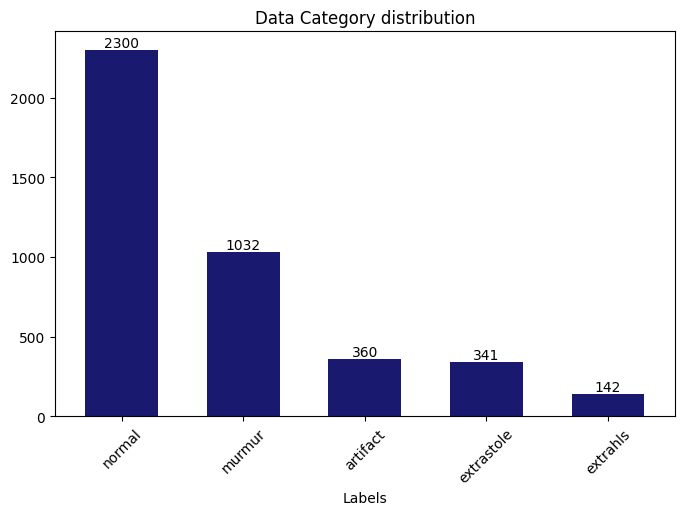

In [ ]:
#Data Distribution Graph
data_distribution(final_data)

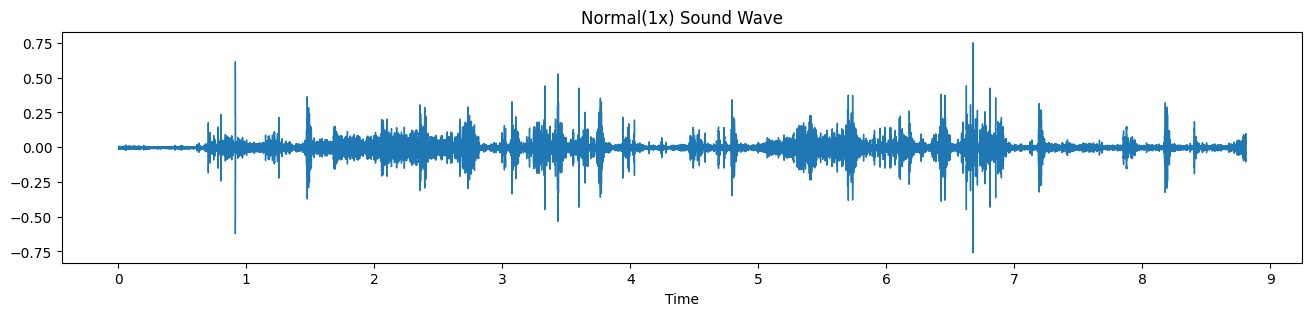

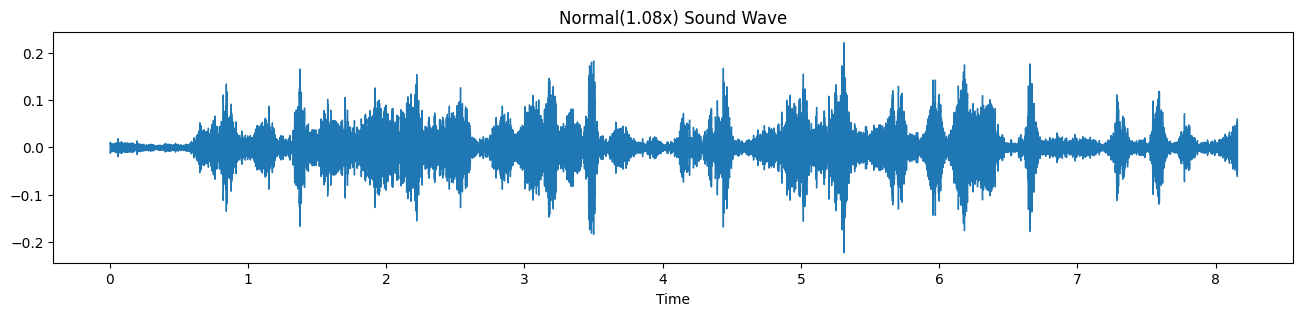

In [ ]:
#Creating waveform for the normal and changed speed sound wave
path = final_data[final_data.label==unique_labels[4]].file_path.iloc[4]
waveform("/content/drive/MyDrive/kaggleAPI/Input/OUT//normal_noisynormal_101_1305030823364_B.wav","Normal(1x)")
waveform("/content/drive/MyDrive/kaggleAPI/Input/OUT///normal_noisynormal_101_1305030823364_B_1.08.wav","Normal(1.08x)")

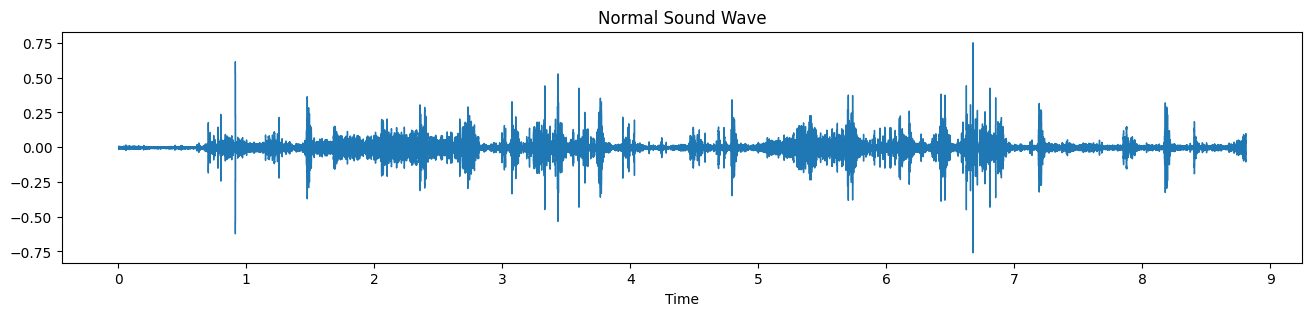

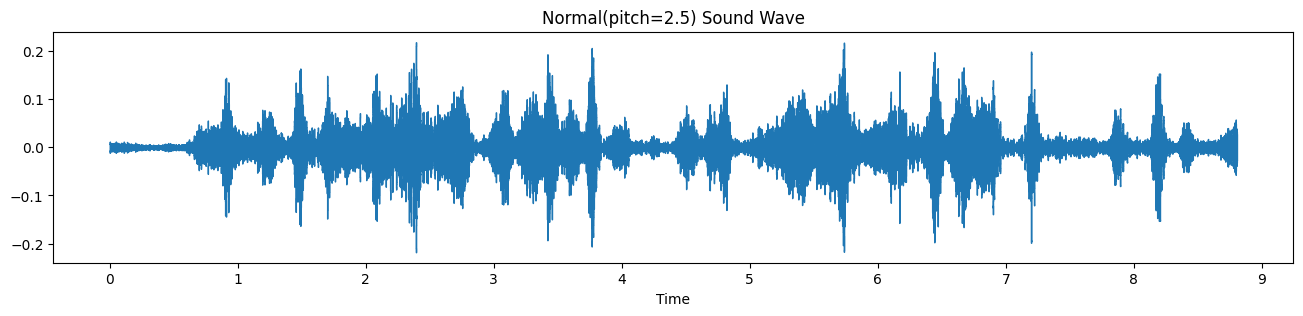

In [ ]:
#Creating waveform for the normal and changed pitch sound wave
path = final_data[final_data.label==unique_labels[4]].file_path.iloc[4]
waveform("/content/drive/MyDrive/kaggleAPI/Input/OUT//normal_noisynormal_101_1305030823364_B.wav","Normal")
waveform("/content/drive/MyDrive/kaggleAPI/Input/OUT//normal_noisynormal_101_1305030823364_B_2.5.wav","Normal(pitch=2.5)")

Data Splitting into Training and Testing Data sets¶


In [ ]:
#Splitting the Data into Training Data and Testing Data in the proportion of 80:20 (Train:Test)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(final_data, final_data.label):
    train_data = final_data.loc[train_idx]
    test_data = final_data.loc[test_idx]

In [ ]:
#Setting the sampling audio rate to 22050, setting the duration only to 3 seconds and finally extraction of MFCC features
def feature_extraction(file_path):
    y, sr = lib.load(file_path, duration=3)
    mfcc = lib.feature.mfcc(y=y, sr=sr,n_mfcc=128)
    return mfcc

In [ ]:
x_train = np.asarray([feature_extraction(train_data.file_path.iloc[i]) for i in (range(len(train_data)))])
x_test = np.asarray([feature_extraction(test_data.file_path.iloc[i]) for i in (range(len(test_data)))])

In [ ]:
#Changing the shape of the Training and Testing inputs to (3340, 128, 130, 1) to meet the CNN input requirements
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

print("X_Train Shape: ", x_train.shape)
print("X_Test Shape: ", x_test.shape)

X_Train Shape:  (3340, 128, 130, 1)
X_Test Shape:  (835, 128, 130, 1)


In [ ]:
#Encode the labels into numbers from string values
encode = LabelEncoder()
y_train = encode.fit_transform(train_data.label)
y_test = encode.fit_transform(test_data.label)

In [ ]:
#Setting 5 labels for each audio example with their probabilities
y_train = to_categorical(y_train,num_classes=5)
y_test = to_categorical(y_test,num_classes=5)

print("Y_Train Shape: ", y_train.shape)
print("Y_Test Shape: ", y_test.shape)

Y_Train Shape:  (3340, 5)
Y_Test Shape:  (835, 5)


In [ ]:

import librosa as lib
import pandas as pd
import numpy as np
import shutil
import soundfile
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint,TensorBoard,ProgbarLogger
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [ ]:


# Create an LSTM model
def create_lstm_model(input_shape, num_classes):
  model = Sequential()

  model.add(Bidirectional(LSTM(128, dropout=0.05, recurrent_dropout=0.20, return_sequences=True), input_shape = input_shape))

  model.add(Dense(128,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(64,activation='relu'))
  model.add(Flatten())

  model.add(Dense(num_classes, activation='softmax'))
  return model


In [ ]:
# Train the LSTM model
def train_lstm_model(model, x_train, y_train, x_test, y_test):
    optimizer = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(1e-4))

    checkpoints = ModelCheckpoint(filepath='lstm_heartbeat_classifier.hdf5', save_best_only=True, verbose=1)

    history = model.fit(x_train, y_train, batch_size=128, epochs=70, validation_data=(x_test, y_test),
                        callbacks=[checkpoints], verbose=1)

    return model, history

In [ ]:
# Evaluate the LSTM model
def evaluate_lstm_model(model, x_test, y_test, encode):
    preds = model.predict(x_test)

    labels = encode.classes_
    y_actual = [labels[np.argmax(y)] for y in y_test]
    y_pred = [labels[np.argmax(pred)] for pred in preds]

    print(classification_report(y_actual, y_pred))

    mat = confusion_matrix(y_actual, y_pred)
    plot_confusion_matrix(conf_mat=mat, figsize=(10, 10), show_normed=True)

Epoch 1/70
27/27 [==============================] - ETA: 0s - loss: 1.2978 - accuracy: 0.5371
Epoch 1: val_loss improved from inf to 1.18822, saving model to lstm_heartbeat_classifier.hdf5
27/27 [==============================] - 61s 2s/step - loss: 1.2978 - accuracy: 0.5371 - val_loss: 1.1882 - val_accuracy: 0.5509
Epoch 2/70


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.1839 - accuracy: 0.5512
Epoch 2: val_loss improved from 1.18822 to 1.16216, saving model to lstm_heartbeat_classifier.hdf5
27/27 [==============================] - 53s 2s/step - loss: 1.1839 - accuracy: 0.5512 - val_loss: 1.1622 - val_accuracy: 0.5509
Epoch 3/70
27/27 [==============================] - ETA: 0s - loss: 1.1455 - accuracy: 0.5512
Epoch 3: val_loss improved from 1.16216 to 1.11081, saving model to lstm_heartbeat_classifier.hdf5
27/27 [==============================] - 54s 2s/step - loss: 1.1455 - accuracy: 0.5512 - val_loss: 1.1108 - val_accuracy: 0.5509
Epoch 4/70
27/27 [==============================] - ETA: 0s - loss: 1.0811 - accuracy: 0.5545
Epoch 4: val_loss improved from 1.11081 to 1.01978, saving model to lstm_heartbeat_classifier.hdf5
27/27 [==============================] - 53s 2s/step - loss: 1.0811 - accuracy: 0.5545 - val_loss: 1.0198 - val_accuracy: 0.5868
Epoch 5/70
27/27 [===========================

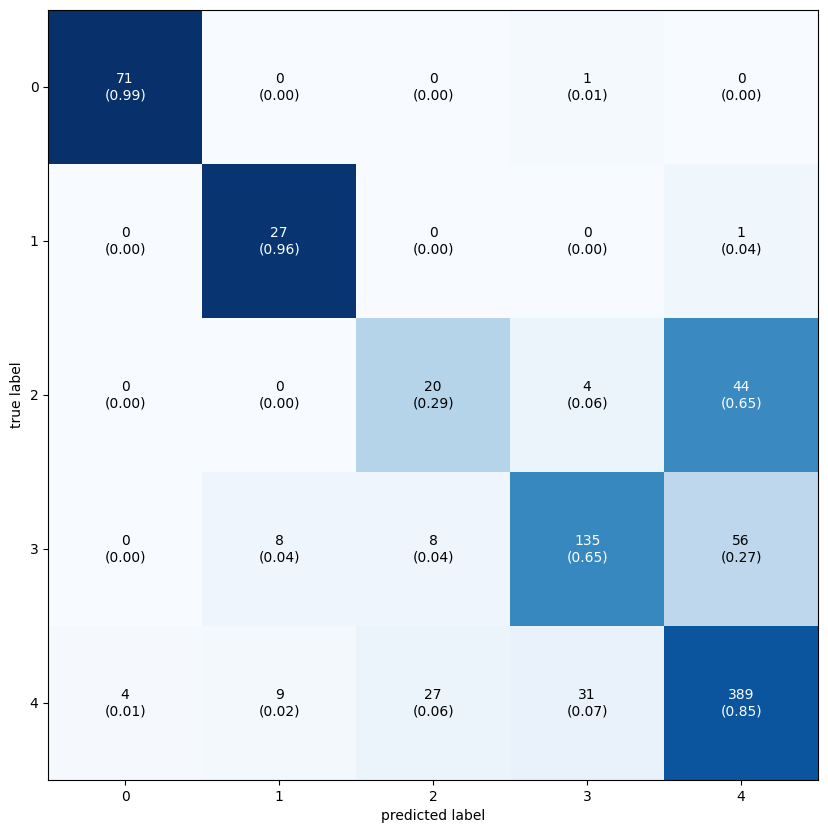

In [ ]:


input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = len(encode.classes_)
lstm_model = create_lstm_model(input_shape, num_classes)
lstm_model, lstm_history = train_lstm_model(lstm_model, x_train, y_train, x_test, y_test)

# Evaluate the model
evaluate_lstm_model(lstm_model, x_test, y_test, encode)
